In [0]:
from __future__ import absolute_import, division, print_function

!pip install tensorflow==2.0.0-alpha0
import tensorflow as tf

In [0]:
import matplotlib.pyplot as plt
% matplotlib inline
import numpy as np
import pandas as pd

In [0]:
from google.colab import drive

drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [0]:
train_path = '/content/drive/My Drive/Colab Notebooks/cs11747/data/class/train.txt' # train set
dev_path = '/content/drive/My Drive/Colab Notebooks/cs11747/data/class/dev.txt' # dev set

In [0]:
def read_dataset(filename):
    data = []
    label = []
    with open(filename, "r") as f:
        for line in f:
            tag, words = line.lower().strip().split(" ||| ")
            data.append(words)
            label.append(tag)
        return pd.DataFrame({'data': data, 'label': label})

In [0]:
train_set = read_dataset(train_path).sample(frac=1)
dev_set = read_dataset(dev_path).sample(frac=1)

In [0]:
train_set.head(5)

,data,label
6838,it may as well be called `` jar-jar binks : th...,0
1866,makes the case for a strong education and good...,3
7249,all the characters are clinically depressed an...,1
140,what saves this deeply affecting film from bei...,3
6716,it 's a fanboy ` what if ? ',2


In [0]:
train_label = tf.keras.utils.to_categorical(train_set['label'], num_classes=5)
dev_label = tf.keras.utils.to_categorical(dev_set['label'], num_classes=5)

In [0]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(pd.concat([train_set['data'], dev_set['data']]))

In [0]:
nwords = len(tokenizer.word_index)
print (nwords)

16218


In [0]:
train_seq = tokenizer.texts_to_sequences(train_set['data'])
dev_seq = tokenizer.texts_to_sequences(dev_set['data'])

47


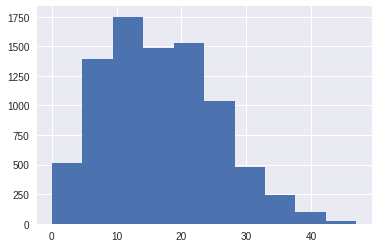

In [0]:
train_len = list(map(lambda x:len(x), train_seq))
plt.hist(train_len)
print (max(train_len))

43


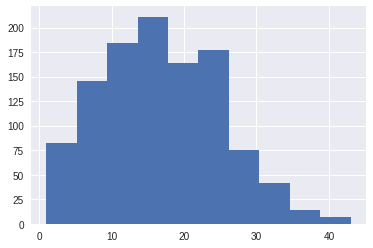

In [0]:
dev_len = list(map(lambda x:len(x), dev_seq))
plt.hist(dev_len)
print (max(dev_len))

In [0]:
train_pad = tf.keras.preprocessing.sequence.pad_sequences(train_seq, maxlen=40)
dev_pad = tf.keras.preprocessing.sequence.pad_sequences(dev_seq, maxlen=40)

In [0]:
train_pad.shape

(8544, 40)

In [0]:
class BoW(tf.keras.Model):
  def __init__(self, nwords, ntags):
    super(BoW, self).__init__()
    self.embed = tf.keras.layers.Embedding(nwords+1, ntags, trainable=True, mask_zero=True)
    self.bias = tf.Variable(tf.zeros([ntags]), trainable=True)
    self.softmax = tf.keras.layers.Softmax(axis=-1)

  def call(self, input):
    """Run the model."""
    result = self.embed(input)
    print (result, self.bias)
    result = tf.nn.bias_add(tf.reduce_sum(result, axis=1), self.bias)
    result = self.softmax(result)
    return result

In [0]:
class CBoW(tf.keras.Model):
  def __init__(self, nwords, ntags, emb_size):
    super(CBoW, self).__init__()
    self.embed = tf.keras.layers.Embedding(nwords+1, emb_size, trainable=True, mask_zero=True)
    self.dense = tf.keras.layers.Dense(ntags, activation='softmax')

  def call(self, input):
    """Run the model."""
    result = self.embed(input)
    result = tf.reduce_sum(result, axis=1)
    result = self.dense(result)
    return result

In [0]:
class DeepCBoW(tf.keras.Model):
  def __init__(self, nwords, ntags, emb_size, n_dense, hidden):
    super(DeepCBoW, self).__init__()
    self.embed = tf.keras.layers.Embedding(nwords+1, emb_size, trainable=True, mask_zero=True)
    self.ls = []
    for i in range(n_dense-1):
        dense = tf.keras.layers.Dense(hidden, activation='tanh')
        self.ls.append(dense)
    self.ls.append(tf.keras.layers.Dense(ntags, activation='softmax'))

  @tf.function
  def call(self, x):
    """Run the model."""
    result = self.embed(x)
    result = tf.reduce_sum(result, axis=1)
    for l in self.ls:
        result = l(result)
    return result

In [0]:
model = DeepCBoW(nwords, 5, 64, 3, 64)
model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer='adam', metrics=[tf.keras.metrics.categorical_accuracy])

In [0]:
history = model.fit(x=train_pad, y=train_label, batch_size=512, epochs=100, validation_data=(dev_pad, dev_label))

Train on 8544 samples, validate on 1101 samples
Epoch 1/100
8544/8544 [==============================] - 1s 65us/sample - loss: 1.5765 - categorical_accuracy: 0.2672 - val_loss: 1.5433 - val_categorical_accuracy: 0.2779
Epoch 2/100
8544/8544 [==============================] - 0s 36us/sample - loss: 1.4351 - categorical_accuracy: 0.3957 - val_loss: 1.4696 - val_categorical_accuracy: 0.3533
Epoch 3/100
8544/8544 [==============================] - 0s 35us/sample - loss: 1.2323 - categorical_accuracy: 0.5447 - val_loss: 1.3897 - val_categorical_accuracy: 0.3851
Epoch 4/100
8544/8544 [==============================] - 0s 38us/sample - loss: 0.9591 - categorical_accuracy: 0.6731 - val_loss: 1.4163 - val_categorical_accuracy: 0.3724
Epoch 5/100
8544/8544 [==============================] - 0s 38us/sample - loss: 0.7128 - categorical_accuracy: 0.7685 - val_loss: 1.5069 - val_categorical_accuracy: 0.3951
Epoch 6/100
8544/8544 [==============================] - 0s 35us/sample - loss: 0.5290 - cat

KeyboardInterrupt: ignored